# <center>Cleaning San Francisco Crime Data</center>
### Prelminaries

In [72]:
%matplotlib inline

import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, FactorAnalysis

# Pandas Configuration
pd.set_option('display.max_columns', 999)

In [73]:
# Submission Example
sample = pd.DataFrame(pd.read_csv('Data/sampleSubmission.csv'))
sample.set_index('Id', inplace=True)
sample.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Import Data

In [74]:
train = pd.DataFrame(pd.read_csv('Data/train.csv'))
test = pd.DataFrame(pd.read_csv('Data/test.csv'))

data = [test, train]

for df in data:
    df.rename(columns={'Dates':'Datetime',
                      'X':'Latitude',
                      'Y':'Longitude'}, 
              inplace=True)
    df.set_index(df['Datetime'], inplace=True)
    df.drop(['Datetime'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

# Dropping incositent feature from training set
train.drop(['Descript','Resolution'], axis=1, inplace=True)

train.shape, test.shape

((878049, 6), (884262, 6))

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 878049 entries, 2015-05-13 23:53:00 to 2003-01-06 00:01:00
Data columns (total 6 columns):
Category      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Address       878049 non-null object
Latitude      878049 non-null float64
Longitude     878049 non-null float64
dtypes: float64(2), object(4)
memory usage: 46.9+ MB


In [76]:
train.head(1)

,Category,DayOfWeek,PdDistrict,Address,Latitude,Longitude
Datetime,,,,,,
2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599


In [77]:
test.head(1)

,Id,DayOfWeek,PdDistrict,Address,Latitude,Longitude
Datetime,,,,,,
2015-05-10 23:59:00,0,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051


### Finding Null Values

In [78]:
train.isnull().sum()

Category      0
DayOfWeek     0
PdDistrict    0
Address       0
Latitude      0
Longitude     0
dtype: int64

In [79]:
test.isnull().sum()

Id            0
DayOfWeek     0
PdDistrict    0
Address       0
Latitude      0
Longitude     0
dtype: int64

### Clearning Up Text Formatting

In [80]:
# Change uppercase string fromatting to tile
train_columns = ['Category', 'DayOfWeek', 'PdDistrict', 'Address']
test_columns = ['PdDistrict','DayOfWeek', 'Address']

for column in train[train_columns]:
    train[column] =  train[column].str.title()
    
for column in train[test_columns]:
    test[column] =  test[column].str.title()

### Removing Outliers

In [81]:
train.shape[0]

878049

##### Longitude and Latitude Observations

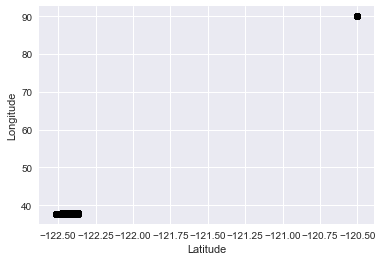

In [82]:
sns.regplot(x=train.Latitude, y=train.Longitude,
            fit_reg=False, color='black')

In [83]:
# removing observations with latitude and longitude outlries
train = train[(np.abs(stats.zscore(train['Latitude'])) < 3)]
train = train[(np.abs(stats.zscore(train['Longitude'])) < 3)]

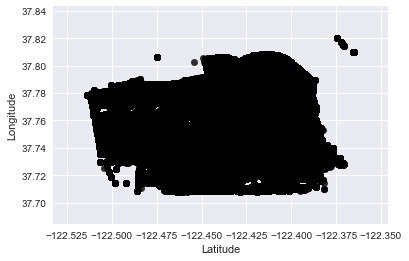

In [84]:
sns.regplot(x=train.Latitude, y=train.Longitude,
            fit_reg=False, color='black')

##### Assessing District Counts

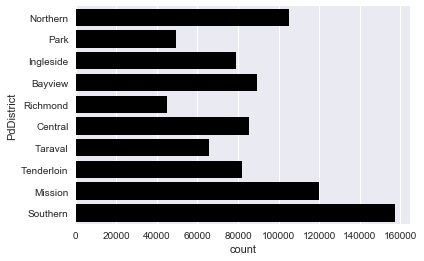

In [85]:
sns.countplot(y=train['PdDistrict'], color='black' )

##### Assesing Target Classes

In [86]:
pd.DataFrame(train['Category'].value_counts()).head()

,Category
Larceny/Theft,174885
Other Offenses,126165
Non-Criminal,92300
Assault,76872
Drug/Narcotic,53971


### Feature Enginering

##### Expanding Datetime Features

In [87]:
data = [train, test]

for df in data:
    df.drop('DayOfWeek', axis=1, inplace=True)
    df['Year'] = df.index.year
    df['Season'] = df.index.quarter
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Day of the Year'] = df.index.dayofyear
    df['Day of the week'] = df.index.dayofweek
    df['Weekend'] = df.index.weekday
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute

##### Enconding Categorical Features

In [88]:
for df in data:
    df[['PdDistrict', 'Address']] = df[['PdDistrict', 'Address']].apply(LabelEncoder().fit_transform)

train['Category'] = LabelEncoder().fit_transform(list(train['Category']))
    

In [89]:
# View dataframe
train.head(1)

,Category,PdDistrict,Address,Latitude,Longitude,Year,Season,Month,Day,Day of the Year,Day of the week,Weekend,Hour,Minute
Datetime,,,,,,,,,,,,,,
2015-05-13 23:53:00,37,4,19762,-122.425892,37.774599,2015,2,5,13,133,2,2,23,53


In [90]:
test.head(1)

,Id,PdDistrict,Address,Latitude,Longitude,Year,Season,Month,Day,Day of the Year,Day of the week,Weekend,Hour,Minute
Datetime,,,,,,,,,,,,,,
2015-05-10 23:59:00,0,0,6407,-122.399588,37.735051,2015,2,5,10,130,6,6,23,59


### Decomposition
##### Factor Analysis

In [91]:
# Convert dataframe to numpy array
train_X = train[train.columns[1:]].values

In [92]:
factor = FactorAnalysis(n_components=1, 
                        random_state=101).fit(train_X)
pd.DataFrame(factor.components_, columns=[train.columns[1:]])

,PdDistrict,Address,Latitude,Longitude,Year,Season,Month,Day,Day of the Year,Day of the week,Weekend,Hour,Minute
0,-0.011743,6046.318195,0.0006,0.002751,-0.028176,0.003114,0.007984,0.046856,0.288815,0.024167,0.024167,0.175742,0.697147


##### Principal Components Analysis

In [93]:
pca = PCA(n_components=1)
pca.fit(train_X)

print ('Explained variance by component: %s' %pca.explained_variance_ratio_)

Explained variance by component: [ 0.99968523]


In [94]:
pd.DataFrame(pca.components_,columns=train.columns[1:])

,PdDistrict,Address,Latitude,Longitude,Year,Season,Month,Day,Day of the Year,Day of the week,Weekend,Hour,Minute
0,-0.000002,1.0,9.929152e-08,4.549447e-07,-0.000005,5.151451e-07,0.000001,0.000008,0.000048,0.000004,0.000004,0.000029,0.000115


### Export Data

In [95]:
# reshape train dataframe before exporting
train =  train[['PdDistrict', 'Address', 'Latitude', 'Longitude', 'Year',
       'Season', 'Month', 'Day', 'Day of the Year', 'Day of the week',
       'Weekend', 'Hour', 'Minute','Category']]

In [96]:
train.to_csv('Data/cleaned_train.csv')
test.to_csv('Data/cleaned_test.csv')

Author: Kavi Sekhon